In [1]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from deep_translator import GoogleTranslator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taufiq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Setup Sastrawi

In [3]:
stop_factory = StopWordRemoverFactory()
stop_words = set(stop_factory.get_stop_words())
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

Merge csv dan menyesuaikan id dengan kategori pesan

In [4]:
messages = pd.read_csv('disaster_messages_translated1.csv', encoding='ISO-8859-1')
categories = pd.read_csv('disaster_categories.csv', encoding='ISO-8859-1')
df = messages.merge(categories, on='id')

categories_split = df['categories'].str.split(';', expand=True)
row = categories_split.iloc[0]
category_colnames = row.apply(lambda x: x.split('-')[0])
categories_split.columns = category_colnames

for column in categories_split:
    categories_split[column] = categories_split[column].apply(lambda x: int(x.split('-')[1]))

df = pd.concat([messages, categories_split], axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2.0,Pembaruan Cuaca - Depan Dingin dari Kuba yang ...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,Apakah badai berakhir atau belum berakhir,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8.0,Mencari seseorang tetapi tidak ada nama,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.0,PBB melaporkan Leogane 80-90 hancur. Hanya Rum...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12.0,"mengatakan: sisi barat Haiti, sisa negara hari...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26386 entries, 0 to 26385
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      26248 non-null  float64
 1   message                 26245 non-null  object 
 2   original                10184 non-null  object 
 3   genre                   26248 non-null  object 
 4   related                 26386 non-null  int64  
 5   request                 26386 non-null  int64  
 6   offer                   26386 non-null  int64  
 7   aid_related             26386 non-null  int64  
 8   medical_help            26386 non-null  int64  
 9   medical_products        26386 non-null  int64  
 10  search_and_rescue       26386 non-null  int64  
 11  security                26386 non-null  int64  
 12  military                26386 non-null  int64  
 13  child_alone             26386 non-null  int64  
 14  water                   26386 non-null

Translate ke bahasa Indonesia

In [6]:
# def translate_text(text):
#     try:
#         return GoogleTranslator(source='auto', target='id').translate(text)
#     except Exception as e:
#         return text 

# df['message'] = df['message'].astype(str).apply(translate_text)
# print(df['message'].head())

In [7]:
# df.to_csv('disaster_messages_translated1.csv', index=False)
# print("Hasil terjemahan telah disimpan ke file 'disaster_messages_translated1.csv'")

Drop kolom original dan hapus missing value

In [8]:
df.drop(columns=['original'], inplace=True)

In [9]:
df = df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26245 entries, 0 to 26247
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      26245 non-null  float64
 1   message                 26245 non-null  object 
 2   genre                   26245 non-null  object 
 3   related                 26245 non-null  int64  
 4   request                 26245 non-null  int64  
 5   offer                   26245 non-null  int64  
 6   aid_related             26245 non-null  int64  
 7   medical_help            26245 non-null  int64  
 8   medical_products        26245 non-null  int64  
 9   search_and_rescue       26245 non-null  int64  
 10  security                26245 non-null  int64  
 11  military                26245 non-null  int64  
 12  child_alone             26245 non-null  int64  
 13  water                   26245 non-null  int64  
 14  food                    26245 non-null  int

Cek jumlah pesan untuk kategori yang dipilih

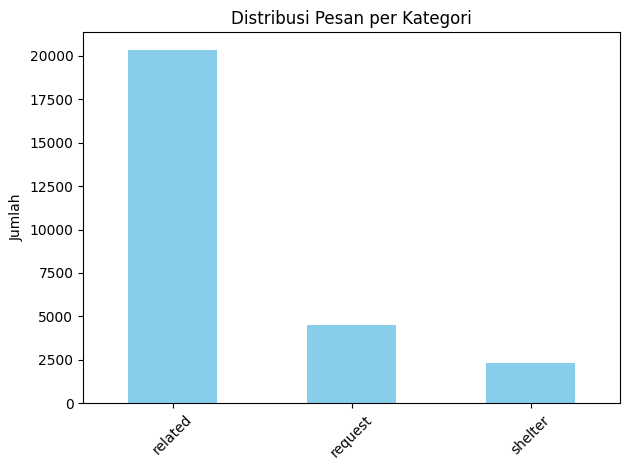

In [11]:
selected_categories = ['related', 'request', 'shelter']

df[selected_categories].sum().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribusi Pesan per Kategori')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
all_text = ' '.join(df['message'].dropna().astype(str).tolist()).lower()
tokens_raw = nltk.word_tokenize(all_text)
token_counts = Counter(tokens_raw)
print("20 kata terbanyak (belum dibersihkan):")
print(token_counts.most_common(20))

20 kata terbanyak (belum dibersihkan):
[(',', 32525), ('.', 26118), ('yang', 19837), ('dan', 18035), ('di', 17959), ('saya', 11419), ('untuk', 10839), ('kami', 5850), ('tidak', 5704), ('dari', 5449), ('dengan', 4775), ('ini', 4587), ('telah', 4030), ('orang', 3840), ('mereka', 3510), ('pada', 3389), (')', 3383), ('(', 3345), ('dalam', 3276), ('air', 3269)]


# Preprocessing

-Mengubah semua huruf menjadi huruf kecil

-Menghapus URL, mention, dan hashtag

-Menghapus semua karakter selain huruf (a-z) dan spasi.

-Memecah teks menjadi token (kata-kata terpisah) menggunakan tokenizer dari NLTK.

-Mengembalikan kata ke bentuk dasarnya

-Menghapus stopwords

In [13]:
df['message'] = df['message'].astype(str).str.lower()
df['message'].head()

0    pembaruan cuaca - depan dingin dari kuba yang ...
1            apakah badai berakhir atau belum berakhir
2              mencari seseorang tetapi tidak ada nama
3    pbb melaporkan leogane 80-90 hancur. hanya rum...
4    mengatakan: sisi barat haiti, sisa negara hari...
Name: message, dtype: object

In [14]:
df['message'] = df['message'].apply(lambda x: re.sub(r"(http|https)?:\/\/\S+|www\.\S+", "", x))
df['message'].head()

0    pembaruan cuaca - depan dingin dari kuba yang ...
1            apakah badai berakhir atau belum berakhir
2              mencari seseorang tetapi tidak ada nama
3    pbb melaporkan leogane 80-90 hancur. hanya rum...
4    mengatakan: sisi barat haiti, sisa negara hari...
Name: message, dtype: object

In [15]:
df['message'] = df['message'].apply(lambda x: re.sub(r"[^a-z\s]", "", x))
df['message'].head()

0    pembaruan cuaca  depan dingin dari kuba yang b...
1            apakah badai berakhir atau belum berakhir
2              mencari seseorang tetapi tidak ada nama
3    pbb melaporkan leogane  hancur hanya rumah sak...
4    mengatakan sisi barat haiti sisa negara hari i...
Name: message, dtype: object

In [16]:
df['message'] = df['message'].apply(nltk.word_tokenize)
df['message'].head()

0    [pembaruan, cuaca, depan, dingin, dari, kuba, ...
1     [apakah, badai, berakhir, atau, belum, berakhir]
2       [mencari, seseorang, tetapi, tidak, ada, nama]
3    [pbb, melaporkan, leogane, hancur, hanya, ruma...
4    [mengatakan, sisi, barat, haiti, sisa, negara,...
Name: message, dtype: object

In [17]:
stop_words.update(['http'])

In [18]:
df['message'] = df['message'].apply(lambda tokens: [t for t in tokens if t not in stop_words and len(t) > 2])
df['message'].head()

0    [pembaruan, cuaca, depan, dingin, kuba, melewa...
1                          [badai, berakhir, berakhir]
2                           [mencari, seseorang, nama]
3    [pbb, melaporkan, leogane, hancur, rumah, saki...
4    [mengatakan, sisi, barat, haiti, sisa, negara,...
Name: message, dtype: object

In [19]:
df['message'] = df['message'].apply(lambda tokens: [stemmer.stem(t) for t in tokens])
df['message'].head()

0     [baru, cuaca, depan, dingin, kuba, lewat, haiti]
1                                [badai, akhir, akhir]
2                                  [cari, orang, nama]
3    [pbb, lapor, leogane, hancur, rumah, sakit, cr...
4    [kata, sisi, barat, haiti, sisa, negara, hari,...
Name: message, dtype: object

Wordcloud

WORDCLOUD - KATEGORI: RELATED


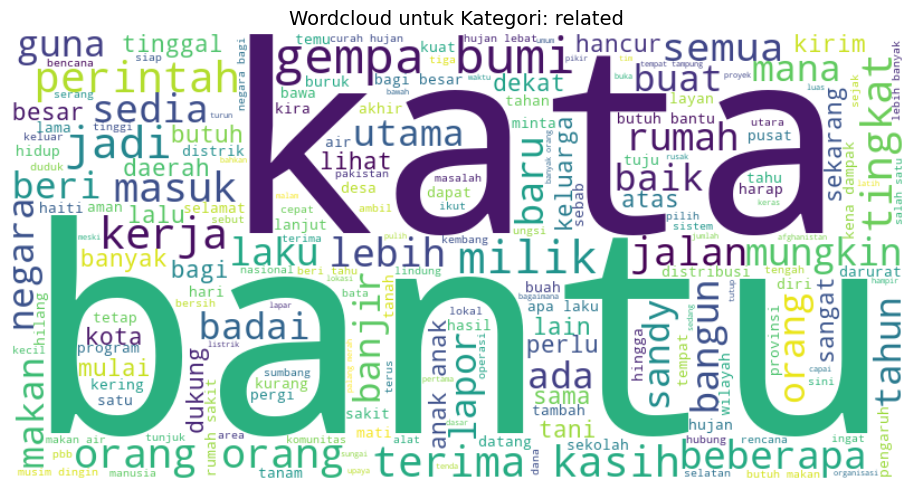

WORDCLOUD - KATEGORI: REQUEST


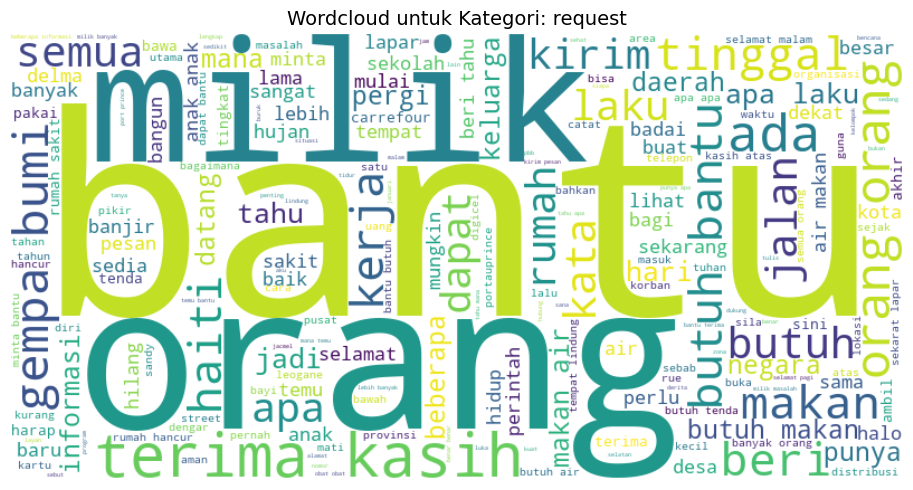

WORDCLOUD - KATEGORI: SHELTER


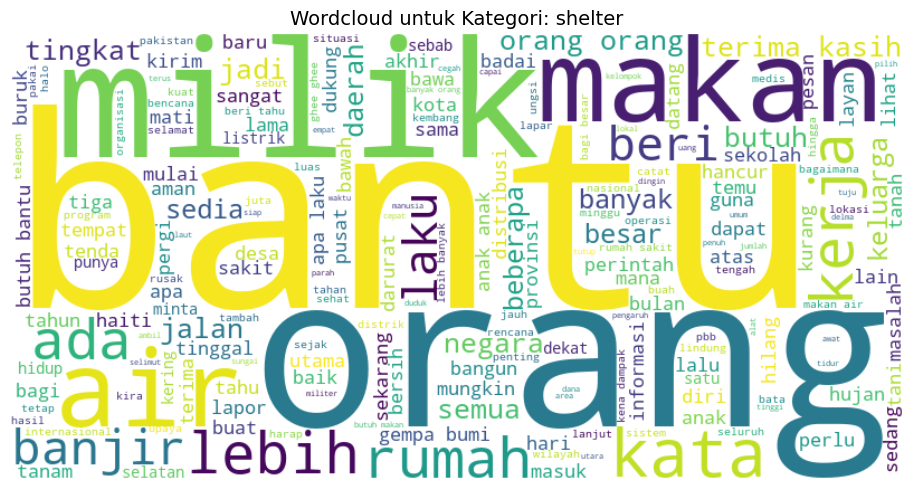

In [20]:
selected_categories = ['related', 'request', 'shelter']

for category in selected_categories:
    print(f"WORDCLOUD - KATEGORI: {category.upper()}")

    df_wc = df[df[category] == 1][['message']].dropna()

    all_words = ' '.join([' '.join(tokens) for tokens in df_wc['message']])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud untuk Kategori: {category}', fontsize=14)
    plt.tight_layout()
    plt.show()


FPM

In [31]:
selected_categories = ['related', 'request', 'missing_people']
for category in selected_categories:
    print(f"FPM - KATEGORI: {category.upper()}")

    df_fpm = df[df[category] == 1][['message']].dropna()
    transactions = df_fpm['message'].tolist()

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    print("\nAnalisis Frequent Itemsets dengan min_support antara 0.1 dan 0.2:")
    for min_support in [0.1, 0.2]:
        print(f"\nmin_support = {min_support}")

        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
        print(frequent_itemsets)

        frequent_itemsets.to_csv(f'frequent_itemsets_{category}_min_support_{min_support}.csv', index=False)

    print("\nAnalisis Frequent Itemsets dengan min_support antara 0.3 dan 0.5:")
    for min_support in [0.3, 0.4, 0.5]:
        print(f"\nmin_support = {min_support}")

        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
        frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

        print(frequent_itemsets)

        frequent_itemsets.to_csv(f'frequent_itemsets_{category}_min_support_{min_support}.csv', index=False)

FPM - KATEGORI: RELATED

Analisis Frequent Itemsets dengan min_support antara 0.1 dan 0.2:

min_support = 0.1
    support itemsets
3  0.159587  (orang)
1  0.156126  (bantu)
2  0.106675  (makan)
0  0.105221    (air)

min_support = 0.2
Empty DataFrame
Columns: [support, itemsets]
Index: []

Analisis Frequent Itemsets dengan min_support antara 0.3 dan 0.5:

min_support = 0.3
Empty DataFrame
Columns: [support, itemsets]
Index: []

min_support = 0.4
Empty DataFrame
Columns: [support, itemsets]
Index: []

min_support = 0.5
Empty DataFrame
Columns: [support, itemsets]
Index: []
FPM - KATEGORI: REQUEST

Analisis Frequent Itemsets dengan min_support antara 0.1 dan 0.2:

min_support = 0.1
    support  itemsets
2  0.222666   (bantu)
6  0.191173   (orang)
4  0.154580   (makan)
3  0.153914   (butuh)
1  0.125083     (apa)
5  0.114881   (milik)
7  0.113107  (terima)
0  0.102240     (air)

min_support = 0.2
    support itemsets
0  0.222666  (bantu)

Analisis Frequent Itemsets dengan min_support antara

Topic Modelling

In [22]:
messages = pd.read_csv('disaster_messages_translated1.csv', encoding='ISO-8859-1')
categories = pd.read_csv('disaster_categories.csv', encoding='ISO-8859-1')
df2 = messages.merge(categories, on='id')

categories_split = df2['categories'].str.split(';', expand=True)
row = categories_split.iloc[0]
category_colnames = row.apply(lambda x: x.split('-')[0])
categories_split.columns = category_colnames

for column in categories_split:
    categories_split[column] = categories_split[column].apply(lambda x: int(x.split('-')[1]))

df2 = pd.concat([messages, categories_split], axis=1)
df2.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2.0,Pembaruan Cuaca - Depan Dingin dari Kuba yang ...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,Apakah badai berakhir atau belum berakhir,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8.0,Mencari seseorang tetapi tidak ada nama,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.0,PBB melaporkan Leogane 80-90 hancur. Hanya Rum...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12.0,"mengatakan: sisi barat Haiti, sisa negara hari...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df2['message']

0        Pembaruan Cuaca - Depan Dingin dari Kuba yang ...
1                Apakah badai berakhir atau belum berakhir
2                  Mencari seseorang tetapi tidak ada nama
3        PBB melaporkan Leogane 80-90 hancur. Hanya Rum...
4        mengatakan: sisi barat Haiti, sisa negara hari...
                               ...                        
26381                                                  NaN
26382                                                  NaN
26383                                                  NaN
26384                                                  NaN
26385                                                  NaN
Name: message, Length: 26386, dtype: object

In [24]:
df2.drop(columns=['original'], inplace=True)

In [25]:
df2 = df2.dropna()

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26245 entries, 0 to 26247
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      26245 non-null  float64
 1   message                 26245 non-null  object 
 2   genre                   26245 non-null  object 
 3   related                 26245 non-null  int64  
 4   request                 26245 non-null  int64  
 5   offer                   26245 non-null  int64  
 6   aid_related             26245 non-null  int64  
 7   medical_help            26245 non-null  int64  
 8   medical_products        26245 non-null  int64  
 9   search_and_rescue       26245 non-null  int64  
 10  security                26245 non-null  int64  
 11  military                26245 non-null  int64  
 12  child_alone             26245 non-null  int64  
 13  water                   26245 non-null  int64  
 14  food                    26245 non-null  int

In [27]:
stop_factory = StopWordRemoverFactory()
stop_words = set(stop_factory.get_stop_words())

english_stopwords = set(['the', 'and', 'is', 'to', 'in', 'on', 'for', 'at', 'by', 'with', 'a', 'an', 'http'])
stop_words.update(english_stopwords)

In [28]:
df2['message'] = df2['message'].astype(str)
df2['message'] = df2['message'].apply(lambda x: re.sub(r"http\S+|www\S+", "", x))  
df2['message'] = df2['message'].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))
df2['message'] = df2['message'].str.lower()
df2['message'] = df2['message'].apply(lambda x: x.split()) 
df2['message'] = df2['message'].apply(lambda tokens: [t for t in tokens if t not in stop_words and len(t) > 2])
df2['message'] = df2['message'].apply(lambda tokens: ' '.join(tokens))
stop_words = list(stop_words)

print(df2['message'].head())

0     pembaruan cuaca depan dingin kuba melewati haiti
1                              badai berakhir berakhir
2                               mencari seseorang nama
3    pbb melaporkan leogane hancur rumah sakit croi...
4    mengatakan sisi barat haiti sisa negara hari m...
Name: message, dtype: object


In [29]:
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(df2['message'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

n_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topik #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))

Topik #0:
gempa hujan bumi lebih banjir orang besar hari musim daerah
Topik #1:
air bantuan negara pemerintah kesehatan lebih daerah termasuk penyakit orang
Topik #2:
anak haiti orang catatan pekerjaan seorang membantu memiliki bagaimana pesan
Topik #3:
orang apa bantuan memiliki rumah kasih terima tahu membutuhkan informasi
Topik #4:
makanan air barang pakaian membutuhkan tenda persediaan selimut memiliki obat
